# Random Forests & Ensembles

Nesse notebook vamos estudar técnicas para combinar o resultado de múltiplos modelos de forma a construir preditores mais poderosos e mitigar alguns dos problemas que surgem nos métodos que já estudamos

In [22]:
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import numpy as np

%matplotlib inline

In [23]:
%load_ext autoreload
%autoreload 2

import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
np.random.seed(42)

plt.rcParams['figure.figsize'] = (8.0, 5.0)

## Relembrando sobre Árvores de Decisão

In [25]:
x, y, target_names = utils.load_dataset('cancer')

print('instancias X features:', x.shape)

instancias X features: (569, 30)


In [26]:
x.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [31]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=100, random_state=42)

In [34]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion='entropy')
dt.fit(xtrain, ytrain)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [35]:
from sklearn.metrics import accuracy_score

ytrain_pred = dt.predict(xtrain)
ytest_pred = dt.predict(xtest)

print('Acurácia no treino:', accuracy_score(ytrain, ytrain_pred))
print('Acurácia no teste:', accuracy_score(ytest, ytest_pred))

Acurácia no treino: 1.0
Acurácia no teste: 0.95


In [ ]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(dt,
                           out_file=None,
                           feature_names=x.columns,
                           class_names=target_names,
                           filled=True, rounded=True, 
                           special_characters=True)
graphviz.Source(dot_data)

Obtivemos uma acurácia no teste de 94%, o que parece bem razoável. Vamos tentar de novo, mas vamos tirar o `random_state=42` do nosso `train_test_split`, o que vai fazer com que os nossos 150 exemplos de teste (e consequentemente os nossos exemplos de treino) sejam sempre diferentes:

In [44]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=150)

dt = DecisionTreeClassifier()
dt.fit(xtrain, ytrain)

accuracy_score(ytest, dt.predict(xtest))

0.96666666666666667

## Fronteiras de Decisão

Podemos visualizar as fronteiras de decisão de cada classificador treinado para entender melhor os erros que eles cometem:

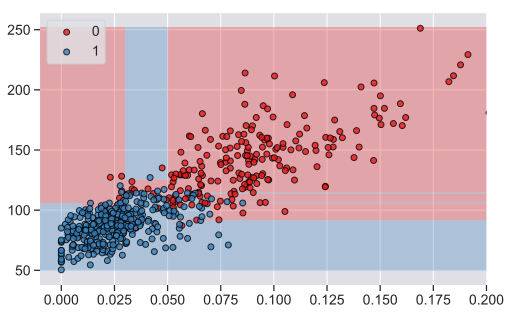

In [55]:
sx = x[['mean concave points', 'worst perimeter']] # selecionando dois atributos

xtrain, xtest, ytrain, ytest = train_test_split(sx, y, test_size=150)

dt = DecisionTreeClassifier()
dt.fit(xtrain, ytrain)
    
utils.plot2d(sx.values, y.values, clf=dt)   # Plota os pontos e a fronteira de decisão

plt.xlim((-0.01, 0.20))
plt.legend(loc=0)

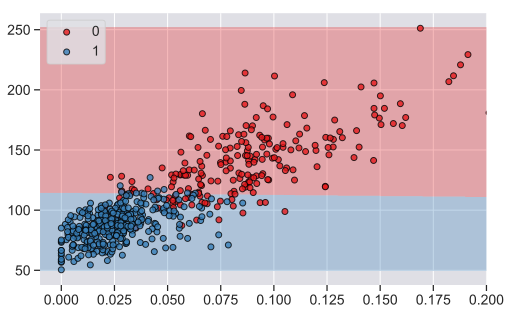

In [52]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(xtrain, ytrain)

utils.plot2d(sx.values, y.values, clf=lr)
plt.xlim((-0.01, 0.20))
plt.legend(loc=0)

## Combining (ensembling)

Temos vários classificadores treinados com árvores de decisão. Cada um deles é enviesado de uma forma diferente. Por que não combinar a opinião de todos eles?

In [56]:
# Recebe um df x e um vetor y e retorna uma amostra de f (0 .. 1)
def sample(x, y, f):
    sx = x.sample(frac=f)
    sy = y.loc[sx.index]
    return sx, sy

In [108]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=100)

accs = []
predictions = []

for r in range(100):
    
    sx, sy = sample(xtrain, ytrain, 0.8)
    
    dt = DecisionTreeClassifier()
    dt.fit(sx, sy)
    yp = dt.predict(xtest)

    predictions.append(yp)

    
predictions = np.array(predictions)

In [109]:
p = np.mean(predictions, axis=0)>0.5
accuracy_score(ytest, p)

0.96999999999999997

0.93000000000000005

In [ ]:
print(np.mean(accs))

# combine!

A técnica que acabamos de usar é um tipo de **ensembling**, mais especificamente um tipo de **bagging**. Nessa aula vamos aprender outras estratégias e formas mais fáceis de implementá-las.

## Random Forest

É muito simples utilizar random forest no nosso dataset:

In [122]:
from sklearn.ensemble import RandomForestClassifier  

rf = RandomForestClassifier(n_estimators=100, max_features=0.5, max_depth=5)
rf.fit(xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=0.5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [123]:
ypred = rf.predict(xtest)
accuracy_score(ytest, ypred)

0.96999999999999997

## Exercício: Inadimplência

Nesse exemplo vamos carregar um dataset novo. Cada exemplo é uma pessoa que pediu uma linha de crédito e devemos decidir a probabilidade dessa pessoa nos pagar de volta, ou não. Algumas coisas que vocês devem fazer:

* Liste os atributos do problema.
* Observe se algum atributo é categório (não numérico).
* Observe se algum atributo tem dados faltantes (nulls e nans).
* Observe se o problema é balanceado (o que é isso mesmo?).
* Separe um conjunto de teste e um de treino (quanto pra cada?)
* Treine uma árvore de decisão, uma regressão logística e uma floresta aleatória.
* Utilizem a função `eval_auc` para estimar qual dos modelos acima é melhor.
* Observe o desempenho ao experimentar com o parâmetro `max_depth` (10, 20, 30, etc). Repare no tempo de execução também.
* Use o parâmetro `n_estimators` de `RandomForestClassifier` para ver como isso impacta o desempenho do seu modelo.
* Plote um gráfico `n_estimators` x `AUC` para sua random forest.
* A partir de qual valor de `n_estimators` você acha que não vale mais a pena aumentar?

In [124]:
from sklearn.metrics import roc_auc_score

def eval_auc(clf, x, y):
    ypred = clf.predict_proba(x)[:,1]
    return roc_auc_score(y, ypred)

In [125]:
x, y = utils.load_default()

In [131]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, stratify=y)

In [142]:
# y.mean()

In [136]:
lr = LogisticRegression()
lr.fit(xtrain, ytrain)

print(eval_auc(lr, xtest, ytest))
# print(accuracy_score(ytest, lr.predict(xtest)))

0.691418125362


In [156]:
dt = DecisionTreeClassifier(max_depth=10)
dt.fit(xtrain, ytrain)

eval_auc(dt, xtest, ytest)

0.81028194358449224

In [154]:
rf = RandomForestClassifier(max_depth=10)
rf.fit(xtrain, ytrain)

eval_auc(rf, xtest, ytest)

0.86258641067776831

In [ ]:
from xgboost import XGBClassifier

gb = XGBClassifier()
gb.fit(xtrain, ytrain)

eval_auc(gb, xtest, ytest)

In [157]:
aucs = []

for n in range(1, 31):

    print(n)
    rf = RandomForestClassifier(n_estimators=n, max_depth=10)
    rf.fit(xtrain, ytrain)

    aucs.append(eval_auc(rf, xtest, ytest))
    

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


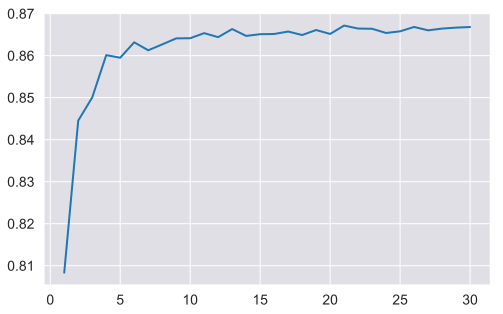

In [158]:
plt.plot(range(1, 31), aucs)

## Ensembling

Nesse exercício vamos observar problemas de overfitting e underfitting e tentar criar ensembles simples parar mitigar tais problemas. Iremos juntos:

* Plotar os dados e observar a correlação entre x e y
* Utilizar `DecisionTreeRegressor` para treinar e visualizar um regressor nesses dados
* Experimentar com alguns parâmetros diferentes e observar os efeitos nos modelos
* Iterar N vezes para treinar N modelos diferentes com diferentes amostras dos dados
* Combinar os resultados de todos os modelos e observar o resultado

In [172]:
def sample(x, y, n):
    idx = np.random.randint(len(x), size=n)
    return x[idx], y[idx]

In [173]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

x, y = utils.load_dataset('regression')

In [176]:
# len(x)

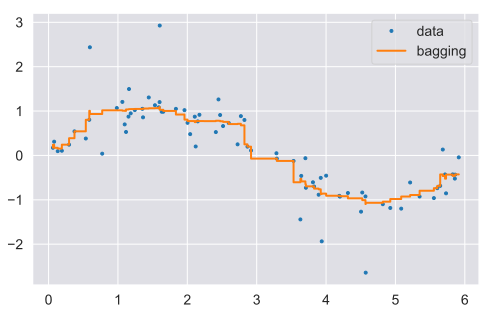

In [205]:
N = 5
train_sample = 0.5

plt.plot(x, y, '.', label="data")

ypreds = []
for n in range(500):
    
    sx, sy = sample(x, y, 40)
    dt = DecisionTreeRegressor(max_depth=4)
    dt.fit(sx, sy)

    ypred = dt.predict(x)
    ypreds.append(ypred)

#     plt.step(x, ypred, label=n)

yp = np.median(ypreds, axis=0)

plt.step(x, yp, label='bagging')
plt.legend()

## Bagging

Nesse exercício vamos experimentar usar a `BaggingClassifier` do sklearn para criar ensembles com regressão logística e árvores de decisão.

In [159]:
from sklearn.ensemble import BaggingClassifier

In [160]:
x, y = utils.load_dataset('default')

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, stratify=y, random_state=1)

In [161]:

n_estimators = [1,2,3,4,5,10,15,20]
dt_bag_scores = []
lr_bag_scores = []

for ne in n_estimators:  # iterar em diferentes valores de numero de estimadores
    
    dt = DecisionTreeClassifier(max_depth=15, random_state=1)
    lr = LogisticRegression(random_state=1)
    
    dt_bag = BaggingClassifier(dt, n_estimators=ne)
    lr_bag = BaggingClassifier(lr, n_estimators=ne)

    dt_bag.fit(xtrain, ytrain)
    lr_bag.fit(xtrain, ytrain)

    dt_bag_scores.append(eval_auc(dt_bag, xtest, ytest))
    lr_bag_scores.append(eval_auc(lr_bag, xtest, ytest))

    print(ne, dt_bag_scores[-1], lr_bag_scores[-1])


1 0.653996155201 0.702255636395
2 0.762169863345 0.694428300109
3 0.788584013945 0.705071514382
4 0.822142271654 0.702076373843
5 0.829266717122 0.705512383248
10 0.845467965118 0.704126385966
15 0.848570284759 0.704753318008
20 0.849079674466 0.703915416196


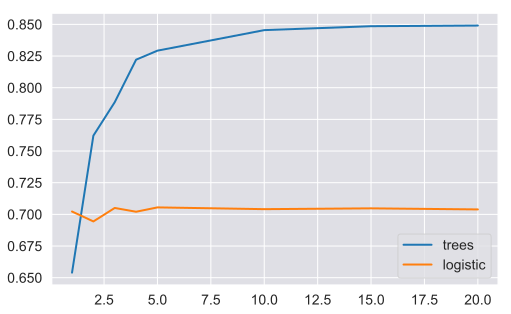

In [163]:
plt.plot(n_estimators, dt_bag_scores, label='trees')
plt.plot(n_estimators, lr_bag_scores, label='logistic')
plt.legend()

Esse resultado talvez deixe claro por que *random forests* são tão populares e não *random logistic regressions* não :)

## Voting

Vamos usar o `VotingClassifier` do `sklearn` para compor alguns classificadores diferentes.

In [164]:
x, y = utils.load_dataset('default')

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, stratify=y, random_state=1)

In [165]:
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

dt1 = DecisionTreeClassifier(random_state=1)
dt2 = DecisionTreeClassifier(max_depth=12, max_features=5, random_state=42)
lr1 = LogisticRegression()
lr2 = LogisticRegression(C=0.001, penalty='l1')
knn = KNeighborsClassifier()

clfs = [('dt1', dt1),
        ('dt2', dt2),
        ('lr1', lr1),
        ('lr2', lr2),
        ('knn', knn)]

vot = VotingClassifier(clfs, voting='soft')
vot.fit(xtrain, ytrain)

VotingClassifier(estimators=[('dt1', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_lea...owski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [166]:
for name, clf in clfs:
    clf.fit(xtrain, ytrain)
    
    auc = eval_auc(clf, xtest, ytest)
    print(name, auc)
    
print()
print('all', eval_auc(vot, xtest, ytest))

dt1 0.608842140619
dt2 0.776249229526
lr1 0.700650119083
lr2 0.661005532367
knn 0.577998903445

all 0.785813464216


## Mini-competição!

Vamos usar os métodos que aprendemos pra tentar melhorar nosso resultado nesse dataset de inadimplência! Usem a criatividade :)

In [167]:
x, y = utils.load_dataset('default')

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, stratify=y, random_state=1)

In [171]:
x.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [169]:
clf = DecisionTreeClassifier(max_depth=10)
clf.fit(xtrain, ytrain)

eval_auc(clf, xtest, ytest)

0.81360774171017369

In [170]:
rf = RandomForestClassifier(n_estimators=100, max_depth=10)
rf.fit(xtrain, ytrain)

eval_auc(rf, xtest, ytest)

0.86144549316384478

## Stacking

Vamos usar os mesmos estimadores base do exemplo anterior, porém ao invés de definir a predição por voto, vamos **treinar outro classificador com as predições dos classificadores base**. Primeiro começamos com nosso split train/test padrão:

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, stratify=y, random_state=1)

Agora precisamos fazer um novo split no conjunto de treino para reservar dados para nosso meta-learner.

In [ ]:
xbase, xmeta, ybase, ymeta = train_test_split(xtrain, ytrain, test_size=0.5, random_state=1)

In [ ]:
xmeta_preds = pd.DataFrame(index=ymeta.index)

# ...

In [ ]:
meta_clf = DecisionTreeClassifier(max_depth=7, random_state=1)
# ...

In [ ]:
xtest_meta = pd.DataFrame(index=ytest.index)

# ...

In [ ]:
eval_auc(meta_clf, xtest_meta, ytest)

## De volta ao Kaggle!

![Comp](taxi-competition.png)

Vamos utilizar as técnicas que aprendemos para treinar modelos pra prever quanto tempo uma viagem de taxi em NY vai levar. Depois vamos submeter nossa solução para o Kaggle.

Dessa vez é pra ganhar!!

In [208]:
df = pd.read_csv('../../19-decision-trees/data/kaggle/train.csv')

In [209]:
print('Instances x features:', df.shape)
df.head()

Instances x features: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Lembrando que já vimos que não precisamos imputar (han??) nenhuma feature:

In [210]:
df.isnull().sum(axis=0)

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

Porém precisamos lidar com algumas variáveis não numéricas:

In [211]:
df.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

Vamos dar uma relembrada rápida na distribuição nosso target (tempo de viagem):

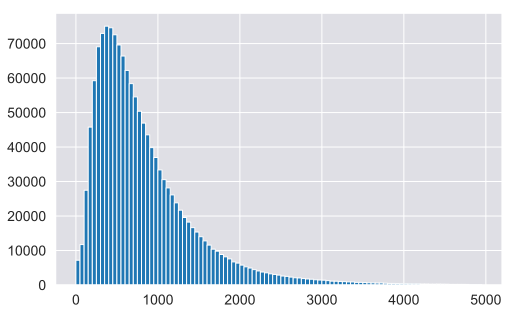

In [212]:
df.trip_duration.hist(bins=range(0,5000,50))

Agora vamos criar nossas features e nosso target:

In [213]:
x = df.drop(['trip_duration', 'id', 'pickup_datetime', 'dropoff_datetime', 'store_and_fwd_flag'], axis=1)
y = df['trip_duration']

In [214]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.1, random_state=1)

In [231]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=8)
reg.fit(xtrain, ytrain)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=8,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [232]:
from sklearn.metrics import mean_absolute_error, mean_squared_log_error

def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

In [233]:
ypred = reg.predict(xtest)

In [234]:
print(mean_absolute_error(ytest, ypred)/60)
print(rmsle(ytest, ypred))

8.02810438223
0.613959135629


In [235]:
print(mean_absolute_error(ytest, ypred)/60)
print(rmsle(ytest, ypred))

8.02810438223
0.613959135629


### Submission

Para montar nossa submissão precisamos:

* Carregar o arquivo CSV
* Aplicar o mesmo pre-processamento que fizemos no treino (que ainda é bem simples)
* Fazer as predições
* Montar e salvar um arquivo CSV

In [236]:
df_sub = pd.read_csv('../../19-decision-trees/data/kaggle/test.csv')

In [237]:
x_sub = df_sub.drop(['id', 'pickup_datetime', 'store_and_fwd_flag'], axis=1)

In [238]:
y_sub = reg.predict(x_sub)

In [240]:
sub = pd.DataFrame({'id': df_sub.id, 'trip_duration': y_sub})
sub.to_csv('../data/kaggle/sub1.csv', index=False)